In [1]:
import os, platform, sys, h5py
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, FloatSlider, Checkbox, FloatRangeSlider

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal

%matplotlib inline
%config InlineBackend.figure_format='retina'

Could not import BEM module. Please do so manually.


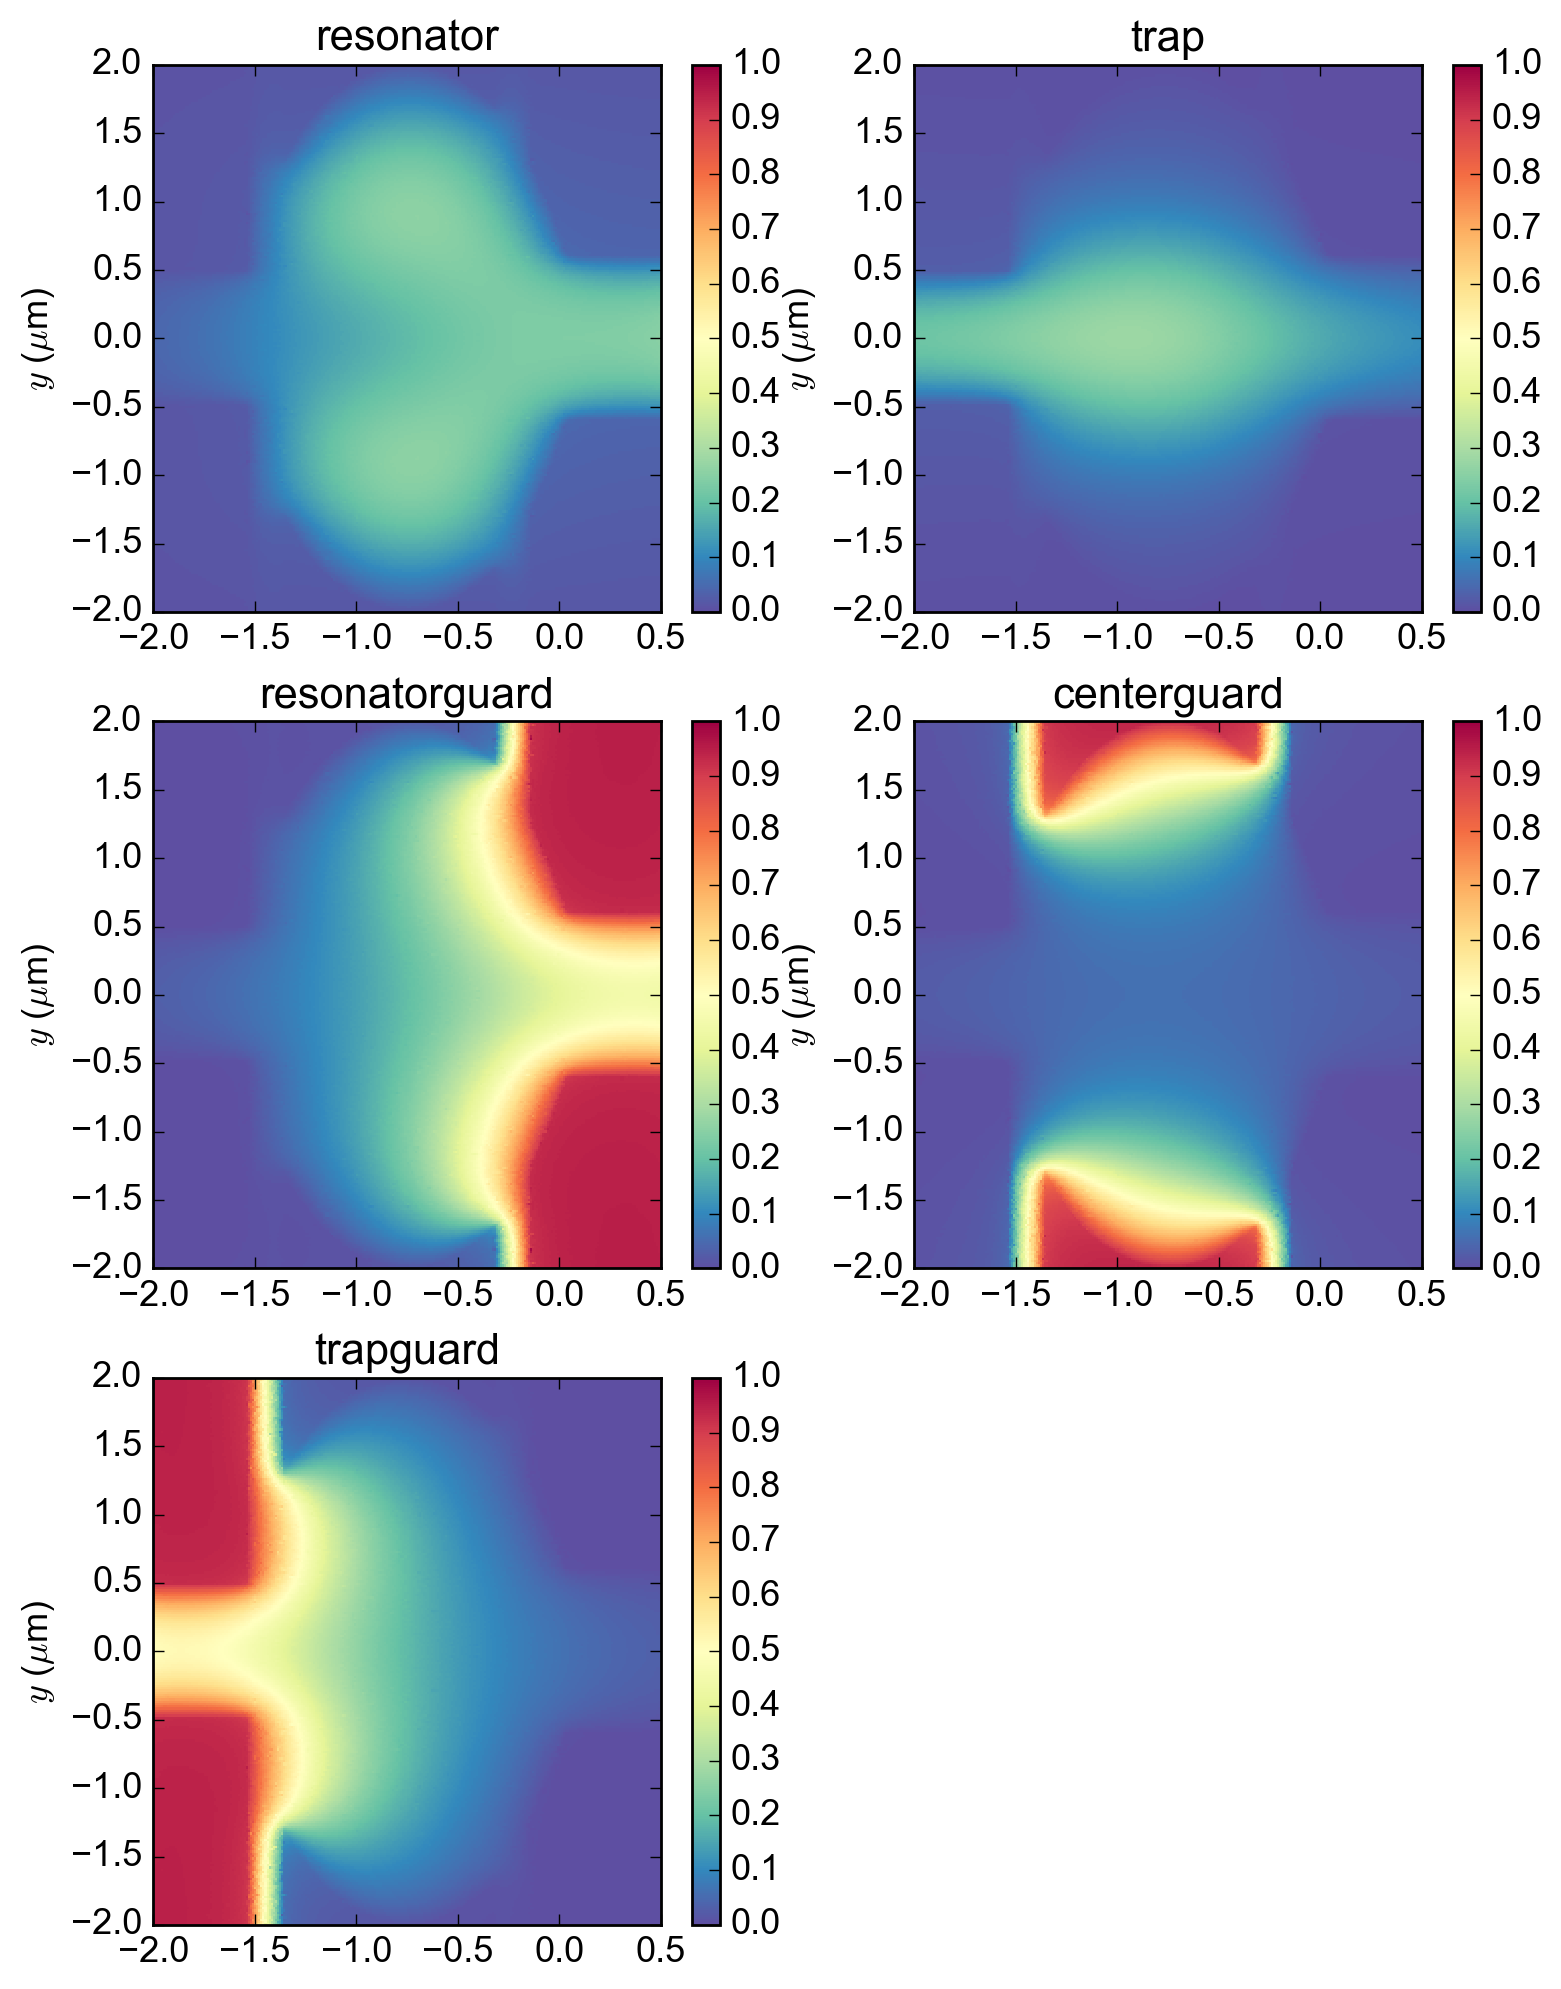

In [2]:
# Evaluate all files in the range. 
xeval=np.linspace(-2, 0.5, 251)

# Do not evaluate the files on the simulation boundary, this gives errors.
# Here I construct an array from y0 to -dy/2, with spacing dy. This limits
# our choice for y-points because, the spacing must be such that there's 
# an integer number of points in yeval. This can only be the case if 
# dy = 2 * ymin / (2*k+1) and Ny = ymin / dy - 0.5 + 1
# yeval = y0, y0 - dy, ... , -3dy/2, -dy/2

y0 = -2.0 # Starting point for y
k = 121 # This defines the sampling
dy = 2*np.abs(y0)/np.float(2*k+1) 
yeval = np.linspace(y0, -dy/2., (np.abs(y0)-0.5*dy)/dy + 1)

master_path = r"/Users/gkoolstra/Desktop/Electron optimization/Realistic potential/Potentials/V6 - Trap Detail"

datafiles = ["Resonator.dsp",
             "Trap.dsp",
             "ResonatorGuard.dsp",
             "CenterGuard.dsp", 
             "TrapGuard.dsp"]

output = list()
names = ['resonator', 'trap', 'resonatorguard', 'centerguard', 'trapguard']
plt.figure(figsize=(9.,12.))
idx = 1

for name, datafile in zip(names, datafiles):
    elements, nodes, elem_solution, bounding_box = trap_analysis.load_dsp(os.path.join(master_path, datafile))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
    xcenter = np.mean(bounding_box[0:2])
    yedge = bounding_box[3]
    xdata -= xcenter
    ydata -= yedge
    xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=xeval, yeval=yeval, 
                                                                  clim=(0, 1.0), plot_axes='xy', 
                                                                  cmap=plt.cm.Spectral_r, plot_mesh=False, 
                                                                  plot_data=False)
    
    # Mirror around the y-axis
    ysize, xsize = np.shape(Uinterp)
    Uinterp_symmetric = np.zeros((2*ysize, xsize))
    Uinterp_symmetric[:ysize, :] = Uinterp
    Uinterp_symmetric[ysize:,:] = Uinterp[::-1,:]
    
    y_symmetric = np.zeros((2*ysize, xsize))
    y_symmetric[:ysize,:] = yinterp
    y_symmetric[ysize:,:] = -yinterp[::-1,:]
    
    x_symmetric = np.zeros((2*ysize, xsize))
    x_symmetric[:ysize,:] = xinterp
    x_symmetric[ysize:,:] = xinterp
    
    plt.subplot(3,2,idx)
    common.configure_axes(13)
    plt.title(name)
    plt.pcolormesh(x_symmetric, y_symmetric, Uinterp_symmetric, cmap=plt.cm.Spectral_r, vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.xlim(np.min(x_symmetric), np.max(x_symmetric))
    plt.ylim(np.min(y_symmetric), np.max(y_symmetric))
    plt.ylabel("$y$ ($\mu$m)")
    
    output.append({'name' : name, 'V' : np.array(Uinterp_symmetric.T, dtype=np.float64),
                   'x' : np.array(x_symmetric.T, dtype=np.float64), 
                   'y' : np.array(y_symmetric.T, dtype=np.float64)})
    
    idx += 1
    
yeval = np.append(yeval, -yeval[::-1])

In [5]:
%matplotlib inline

t = trap_analysis.TrapSolver()
x, y, cropped_potentials = t.crop_potentials(output, xdomain=(-2.0,2.0), ydomain=(-2.0, 2.0))
import matplotlib as mpl
common.configure_axes(13)
mpl.rcParams['figure.figsize'] = (12.,5.)

def Visualize(resonator=+2.25, trap=+1.20, resonatorguard=-3.0, centerguard=-0.0, trapguard=-3.0, 
              scaling=0.0, colors=0.0, 
              resonator_trap_locked=False, left_right_guard_locked=False, 
              auto_scale=True):
    
    color_minimum, color_maximum = ColorSlider.value
    
    fig = plt.figure()
    plt1 = fig.add_subplot(1,2,1)
    plt2 = fig.add_subplot(1,2,2)
    
    if resonator_trap_locked:
        trap = resonator
    if left_right_guard_locked:
        resonatorguard = trapguard
    coefficients = np.array([resonator, trap, resonatorguard, centerguard, trapguard]) * 10**scaling
    combined_potential = t.get_combined_potential(cropped_potentials, coefficients)
    #plt.pcolormesh(x*1E6, y*1E6, combined_potential, cmap=plt.cm.RdBu_r, vmin=-1, vmax=1)
    #plt1.imshow(combined_potential, extent=[min(x)*1E6, max(x)*1E6, min(y)*1E6, max(y)*1E6], cmap=plt.cm.RdBu_r,
    #           aspect='auto', interpolation='none')
    if not auto_scale:
        plt1.pcolormesh(x, y, combined_potential, cmap=plt.cm.RdBu_r, 
                        vmin=color_minimum, vmax=color_maximum)
    else:
        plt1.pcolormesh(x, y, combined_potential, cmap=plt.cm.RdBu_r)
    
    if True:
        yidx,xidx = np.where(combined_potential==np.max(combined_potential))
    else: 
        yidx = np.array([common.find_nearest(y, 0.0)])
        xidx = np.array([common.find_nearest(x, 0.0)])
    plt1.plot(x[xidx], y[yidx], 'o', **common.plot_opt("black"))
        
    plt1.set_xlabel("x ($\mu$m)")
    plt1.set_ylabel("y ($\mu$m)")
    
    Vdata = combined_potential[:,xidx[0]]
    xdata = y
    plt2.plot(xdata, Vdata, '.k')
    
    try:
        fr, ferr = t.fit_electron_potential(xdata, Vdata, fitdomain=(-0.25, +0.25), do_plot=False)
        plt2.plot(xdata, kfit.parabolafunc(xdata, *fr), '-r', lw=2.0)
        f0, sigmaf0 = t.get_electron_frequency(fr, ferr, verbose=False)
    except:
        f0, sigmaf0 = 0, 0
    
    plt2.set_xlabel("x ($\mu$m)")
    plt2.set_ylabel("Potential (V)")
    plt2.set_xlim(min(xdata), max(xdata))
    plt.gca().set_axis_bgcolor('none')
    
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt2.text(xmin + 0.1*(xmax-xmin), ymin + 0.1*(ymax-ymin), "f = %.3f +/- %.3f GHz"%(f0/1E9, sigmaf0/1E9))
    
    biasVoltages = "$V_{res}$ = %.8f\n$V_{trap}$ = %.8f\n$V_{rguard}$ = %.8f\n$V_{cguard}$ = %.8f\n$V_{tguard}$ = %.8f\n" % \
    (resonator * 10**scaling, trap * 10**scaling, resonatorguard * 10**scaling, centerguard * 10**scaling, trapguard * 10**scaling)
    
    plt2.text(2, ymin + 0.1*(ymax-ymin), biasVoltages)
    plt.show()
    
ResSlider = FloatSlider(value=1.0, min=-2.0, max=3.0, step=0.005, description='$V_{res}$', 
                       slider_color="#ff6666", )
TrapSlider = FloatSlider(value=1.0, min=-2.0, max=3.0, step=0.005, description='$V_{trap}$', 
                       slider_color="#ff6666")
RGSlider = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.05, description='$V_{rguard}$', 
                       slider_color="#3366ff")
CGSlider = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.05, description='$V_{cguard}$', 
                       slider_color="#3366ff")
TGSlider = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.05, description='$V_{tguard}$', 
                       slider_color="#3366ff")
nsSlider = FloatSlider(value=0.0, min=12, max=13, step=0.05, description='$^{10}$log($n_s$)')
ColorSlider = FloatRangeSlider(value=(0, 0.5), min=-0.5, max=0.5, step=0.05, description="Colorbar")
AutoScaleBox = Checkbox(value=False, description="Auto scale?")
LockGuards = Checkbox(value=False, description="Lock guards")
LockResTrap = Checkbox(value=False, description="Lock res & trap")

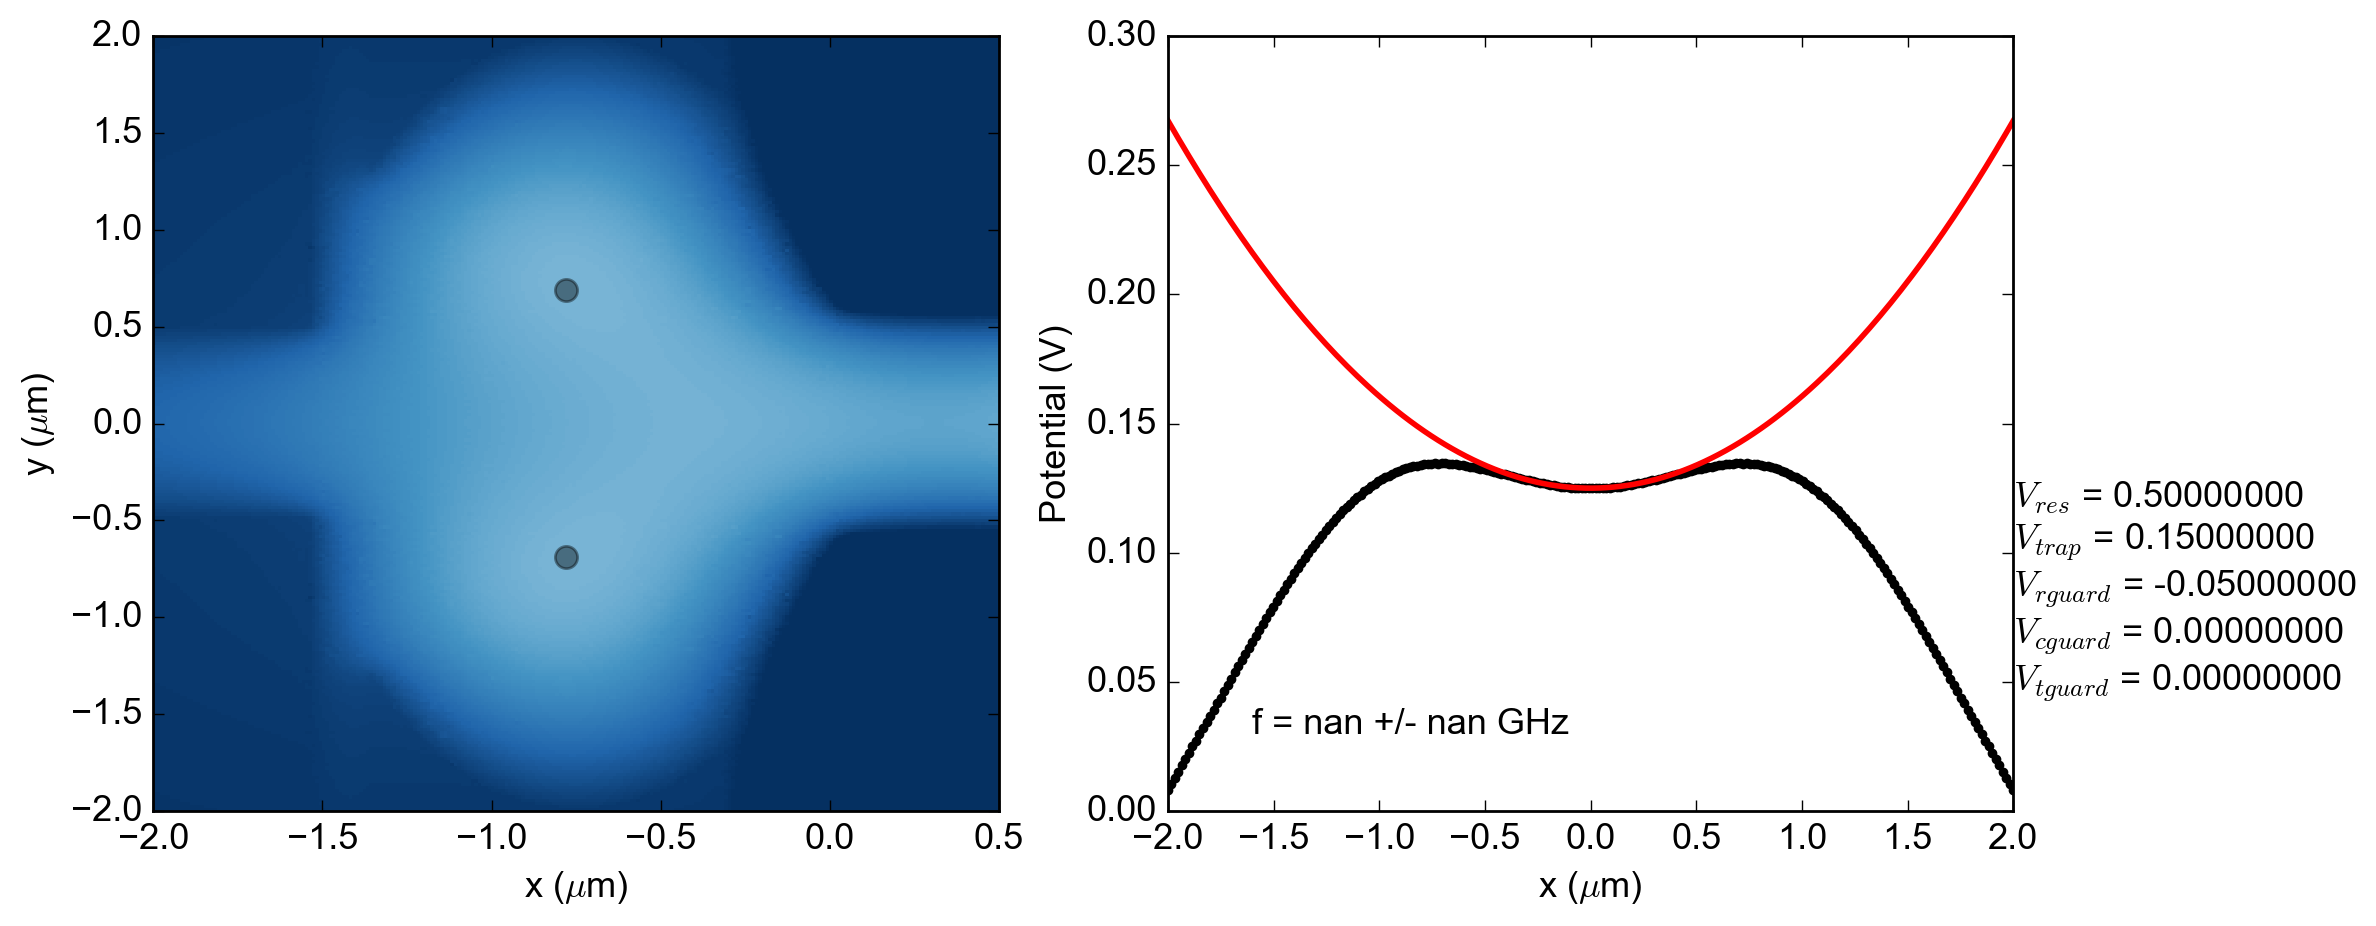

In [6]:
interact(Visualize, resonator=ResSlider, trap=TrapSlider, 
         resonatorguard=RGSlider, centerguard=CGSlider, trapguard=TGSlider, scaling=(-2.0, 1.0, 0.01),
         colors=ColorSlider,
         resonator_trap_locked=LockResTrap, left_right_guard_locked=LockGuards, 
         auto_scale=AutoScaleBox, continuous_update=False);